# Business Case: LoanTap Logistic Regression

## Problem Statement

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

Personal Loan
EMI Free Loan
Personal Overdraft
Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

**Problem Statement:**

Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations.

Predicts the who can pay loan fully and who can not.

In [697]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score

In [613]:
data = pd.read_csv('loan.csv')

In [614]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


## Exploratory Data Analysis

In [615]:
data.shape

(396030, 27)

In [616]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [617]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [618]:
print("Percentage of missing value")
np.round((data.isna().sum()/data.shape[0])*100,2)

Percentage of missing value


loan_amnt               0.00
term                    0.00
int_rate                0.00
installment             0.00
grade                   0.00
sub_grade               0.00
emp_title               5.79
emp_length              4.62
home_ownership          0.00
annual_inc              0.00
verification_status     0.00
issue_d                 0.00
loan_status             0.00
purpose                 0.00
title                   0.44
dti                     0.00
earliest_cr_line        0.00
open_acc                0.00
pub_rec                 0.00
revol_bal               0.00
revol_util              0.07
total_acc               0.00
initial_list_status     0.00
application_type        0.00
mort_acc                9.54
pub_rec_bankruptcies    0.14
address                 0.00
dtype: float64

- ### Univariate Analysis

In [619]:
for i in data.columns:
    print(i,":",data[i].nunique())

loan_amnt : 1397
term : 2
int_rate : 566
installment : 55706
grade : 7
sub_grade : 35
emp_title : 173105
emp_length : 11
home_ownership : 6
annual_inc : 27197
verification_status : 3
issue_d : 115
loan_status : 2
purpose : 14
title : 48817
dti : 4262
earliest_cr_line : 684
open_acc : 61
pub_rec : 20
revol_bal : 55622
revol_util : 1226
total_acc : 118
initial_list_status : 2
application_type : 3
mort_acc : 33
pub_rec_bankruptcies : 9
address : 393700


In [620]:
for i in data.columns:
    print(i)
    print(data[i].value_counts())
    print("____________________________________________________")

loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
           ...  
36625.0        1
37450.0        1
36275.0        1
38225.0        1
725.0          1
Name: loan_amnt, Length: 1397, dtype: int64
____________________________________________________
term
 36 months    302005
 60 months     94025
Name: term, dtype: int64
____________________________________________________
int_rate
10.99    12411
12.99     9632
15.61     9350
11.99     8582
8.90      8019
         ...  
17.34        1
14.38        1
14.62        1
14.70        1
22.64        1
Name: int_rate, Length: 566, dtype: int64
____________________________________________________
installment
327.34    968
332.10    791
491.01    736
336.90    686
392.81    683
         ... 
379.56      1
234.62      1
306.54      1
159.18      1
565.59      1
Name: installment, Length: 55706, dtype: int64
____________________________________________________
grade
B    116018
C    105987
A     64187
D   

In [621]:
np.round((data['loan_status'].value_counts()/data.shape[0])*100,2)

Fully Paid     80.39
Charged Off    19.61
Name: loan_status, dtype: float64

In [622]:
np.round((data['home_ownership'].value_counts()/data.shape[0])*100,2)

MORTGAGE    50.08
RENT        40.35
OWN          9.53
OTHER        0.03
NONE         0.01
ANY          0.00
Name: home_ownership, dtype: float64

In [623]:
np.round((data[(data.grade=='A') & (data.loan_status=="Fully Paid")].shape[0]/data[(data.grade=='A')].shape[0])*100,2)

93.71

In [624]:
data_cat = []
data_num = []
for i in data.columns:
    if data[i].nunique()<50:
        data_cat.append(i)
    else:
        data_num.append(i)

In [625]:
data_cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'pub_rec',
 'initial_list_status',
 'application_type',
 'mort_acc',
 'pub_rec_bankruptcies']

In [626]:
data_num.remove('issue_d')
data_num.remove('emp_title')
data_num.remove('earliest_cr_line')
data_num.remove('address')
data_num.remove('title')

In [627]:
data_num

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc']

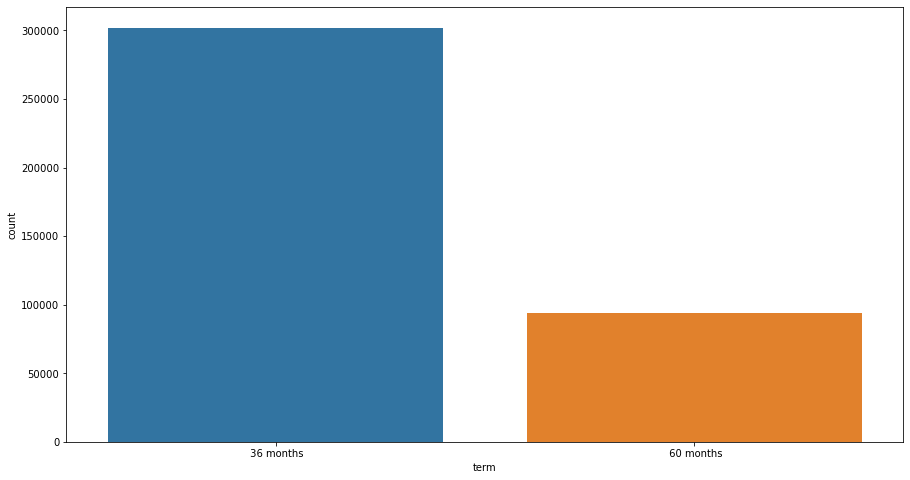

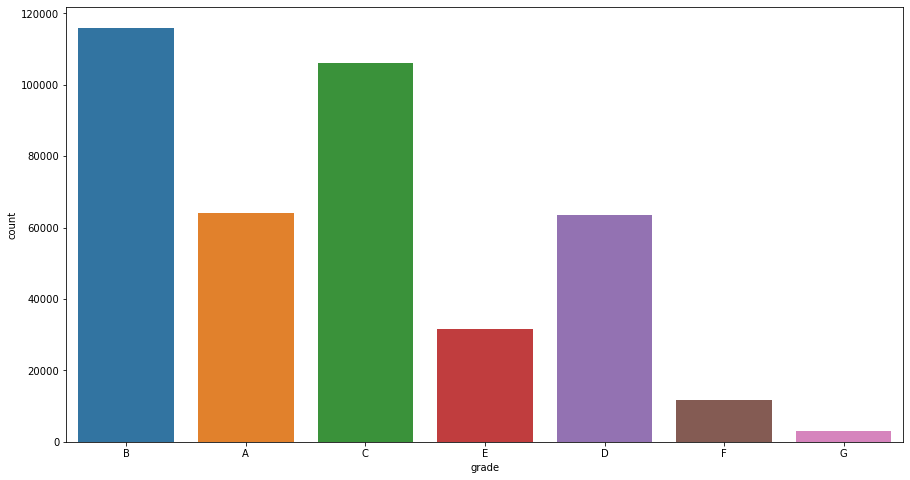

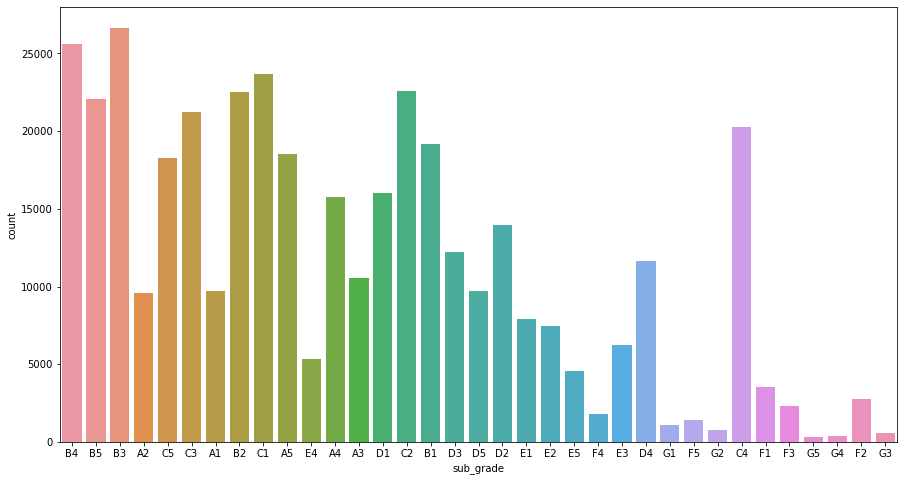

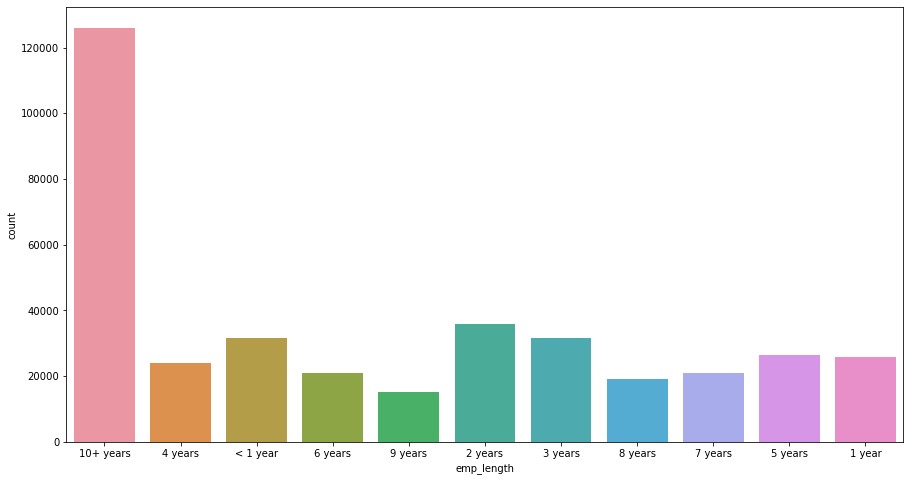

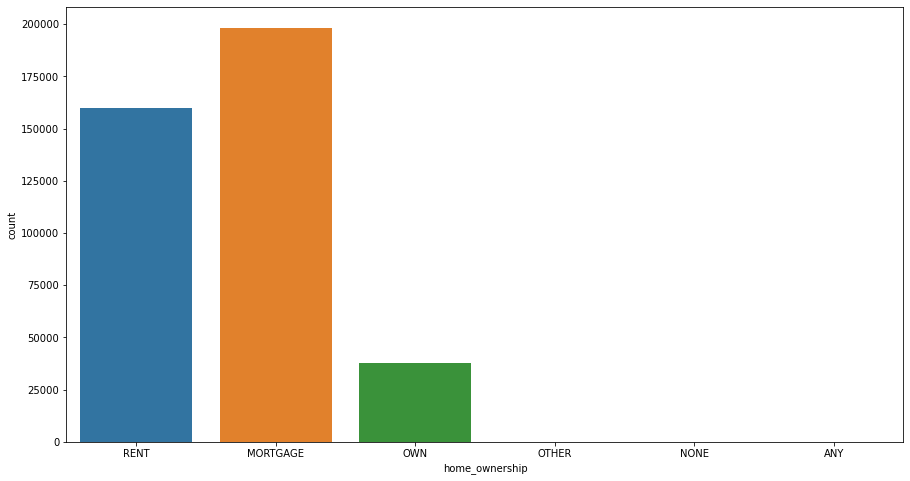

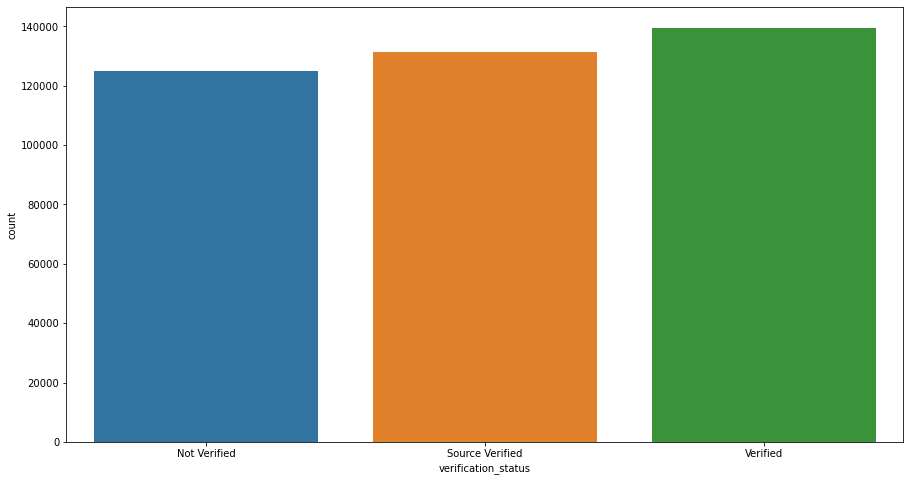

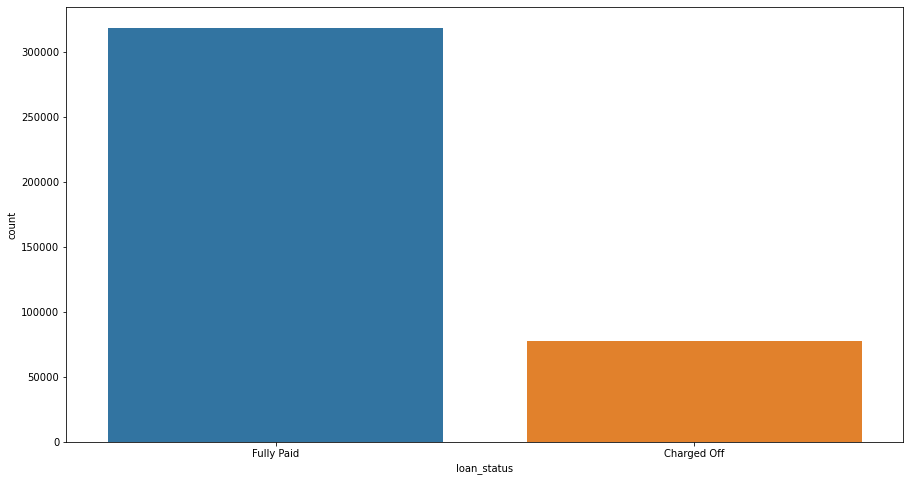

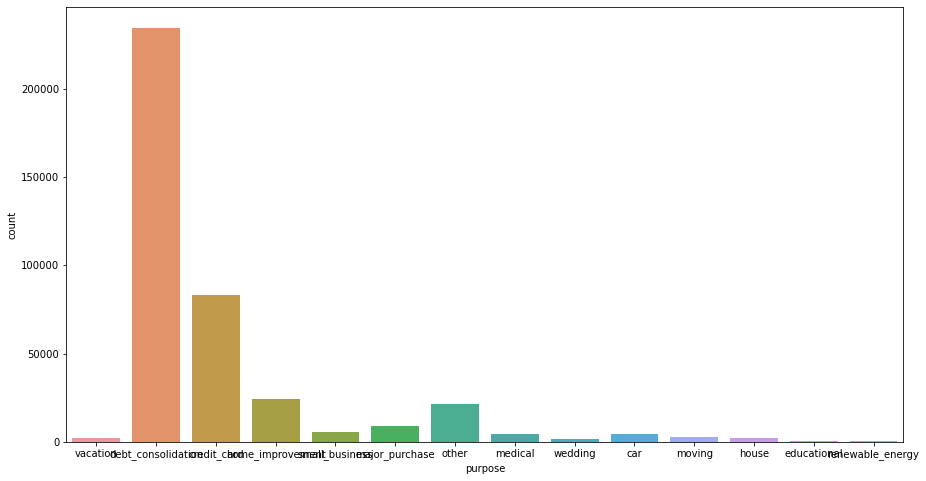

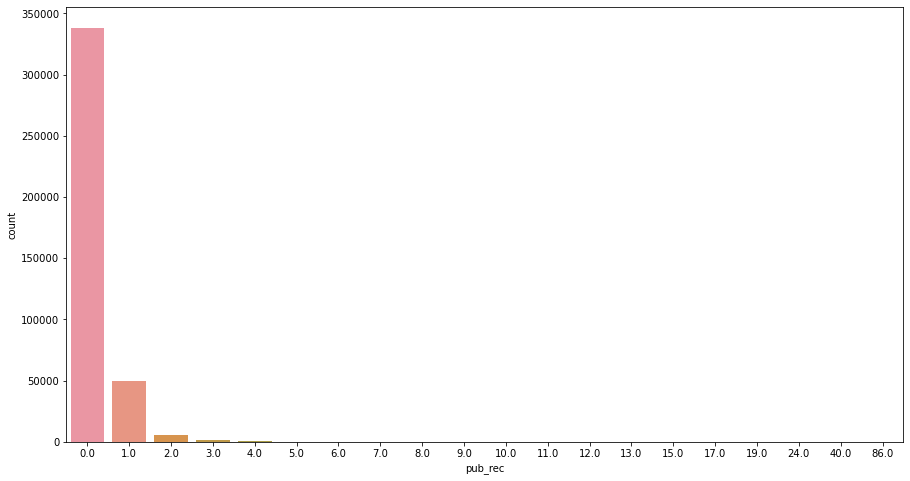

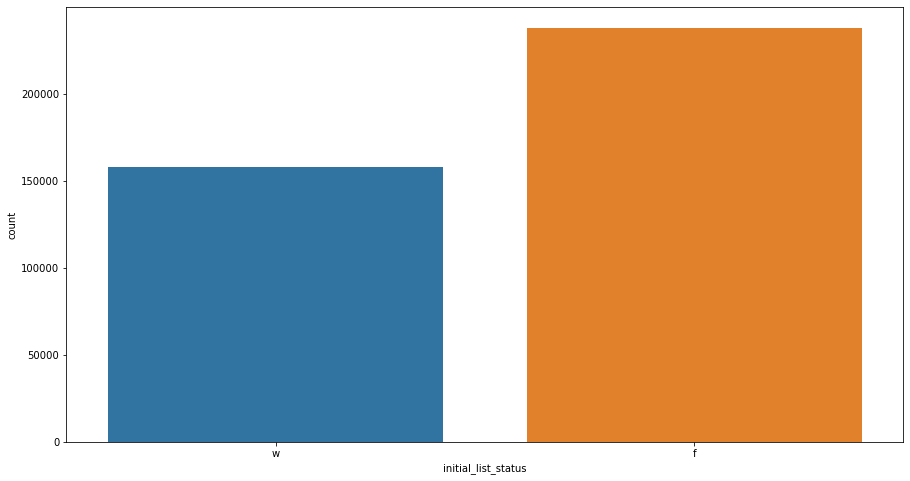

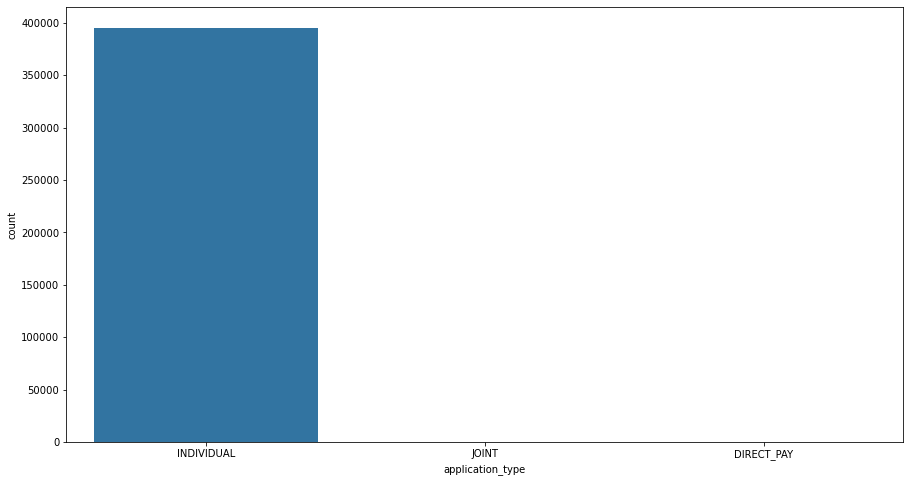

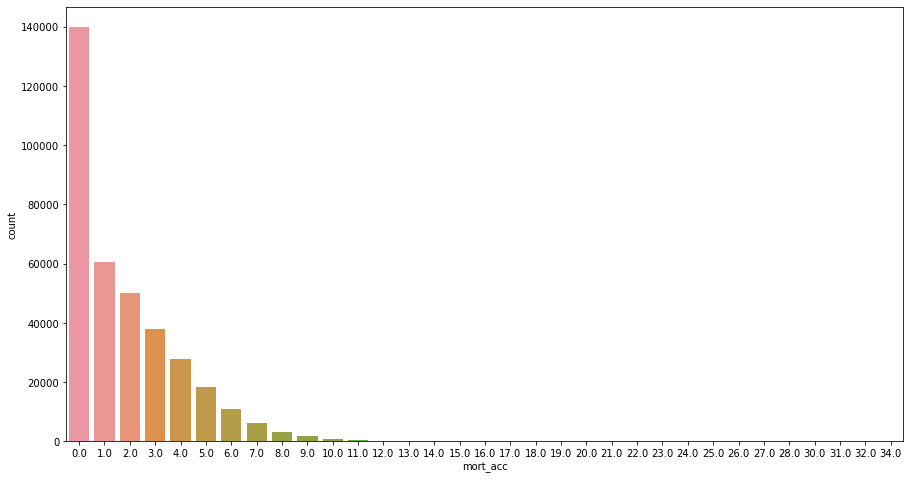

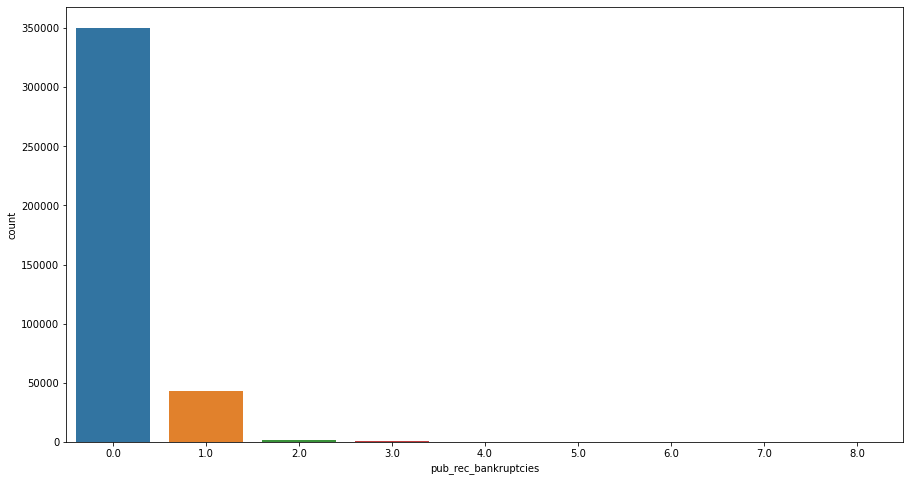

In [628]:
for i in data_cat:
    plt.figure(i,figsize=(15,8))
    sns.countplot(x=i,data=data)

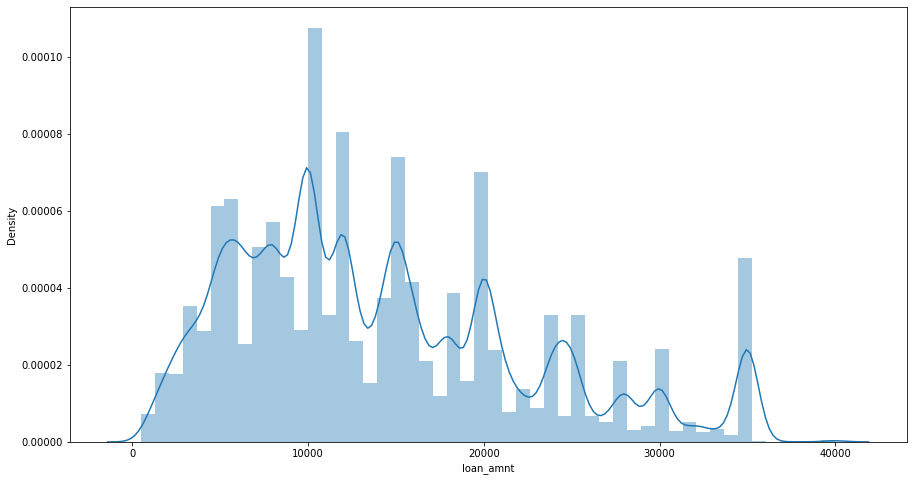

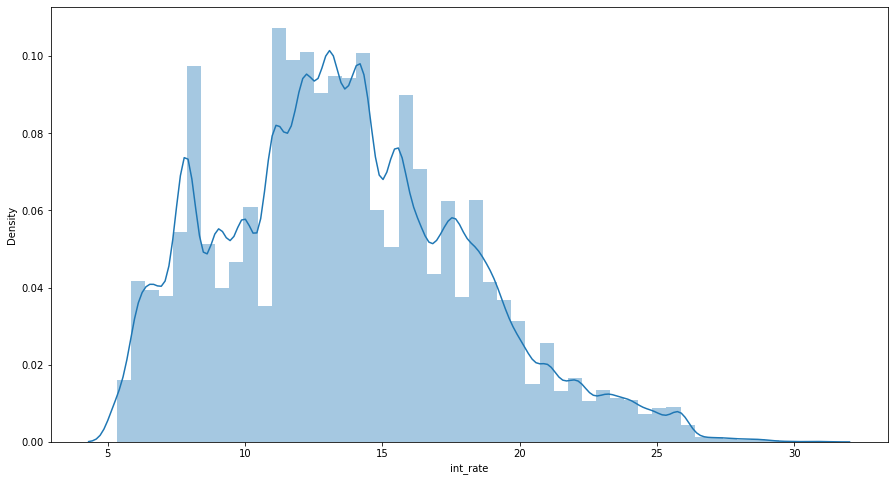

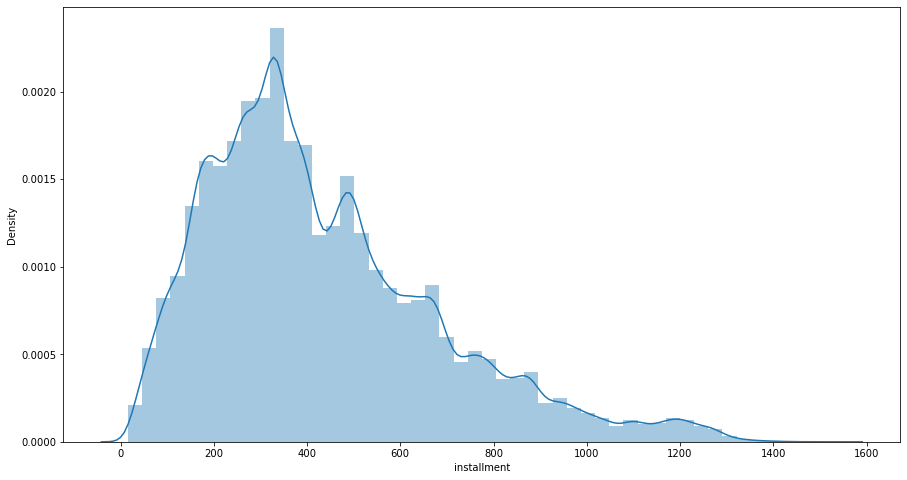

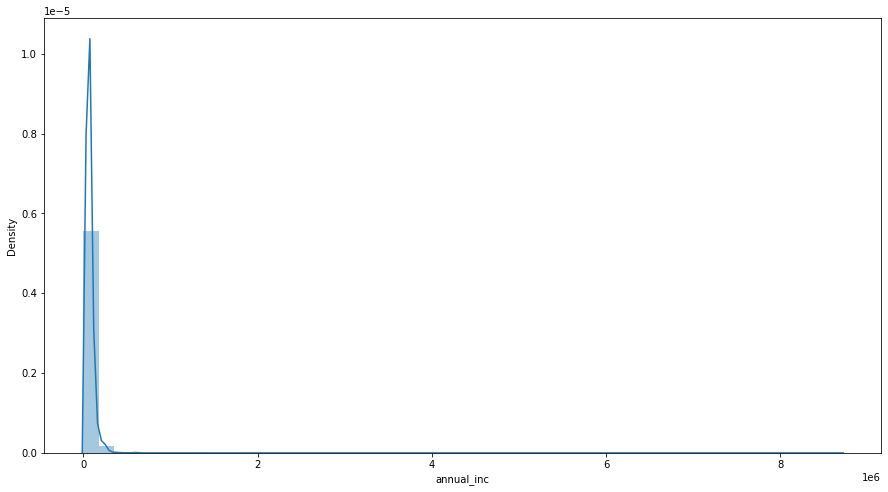

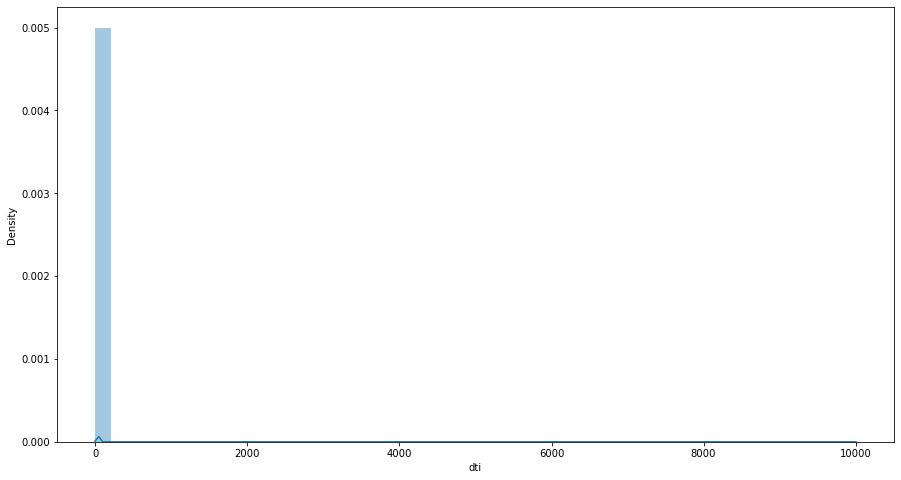

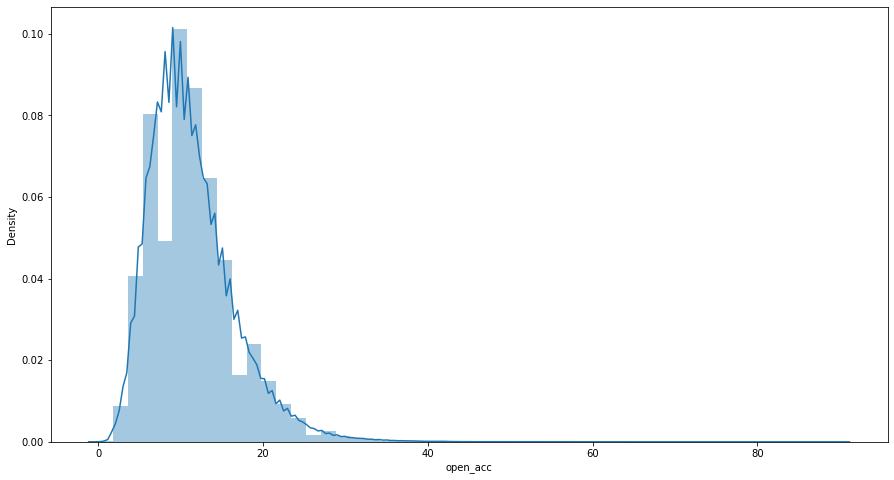

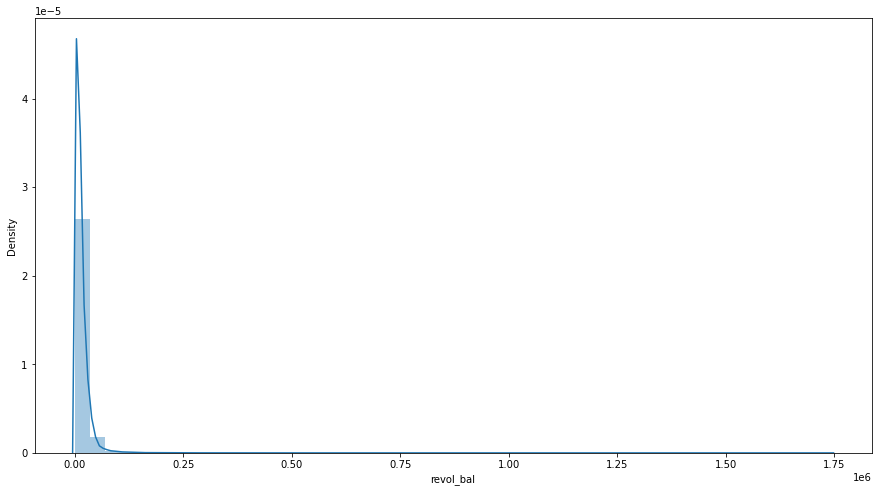

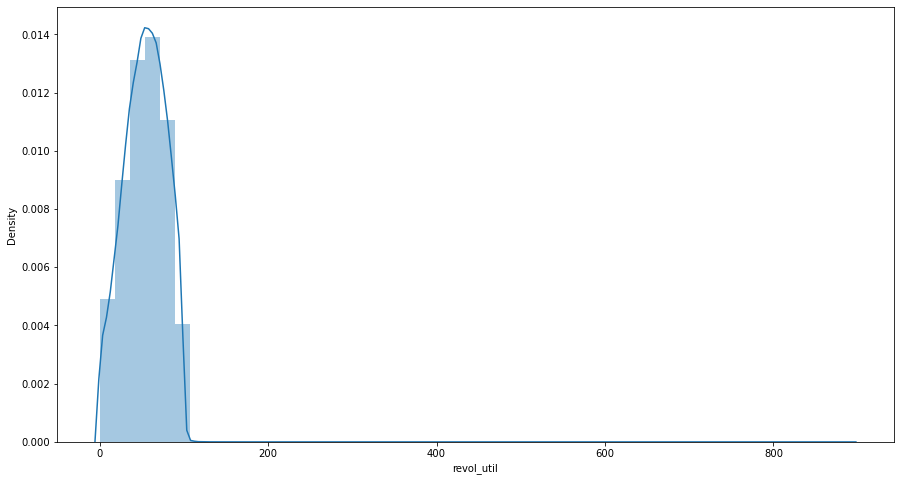

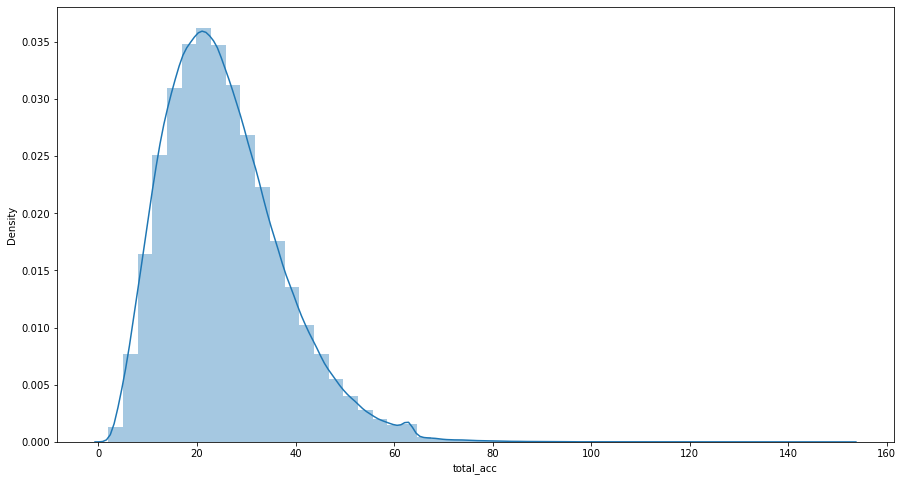

In [629]:
for i in data_num:
    plt.figure(i,figsize=(15,8))
    sns.distplot(data[i])

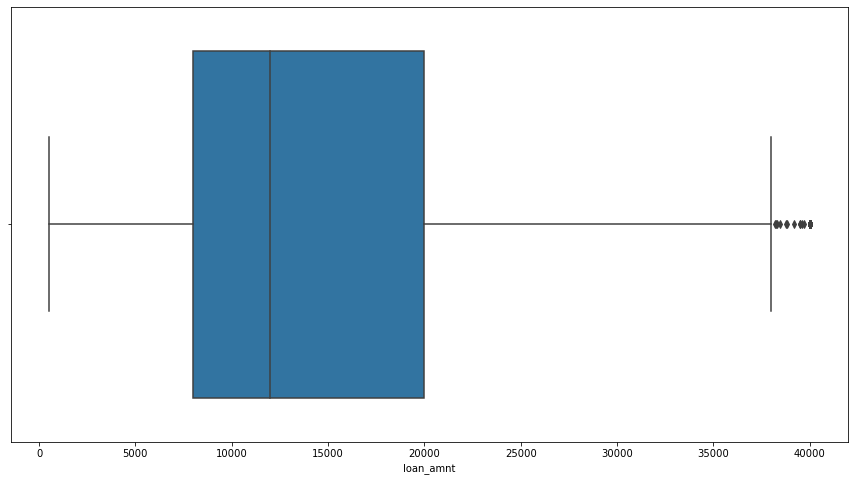

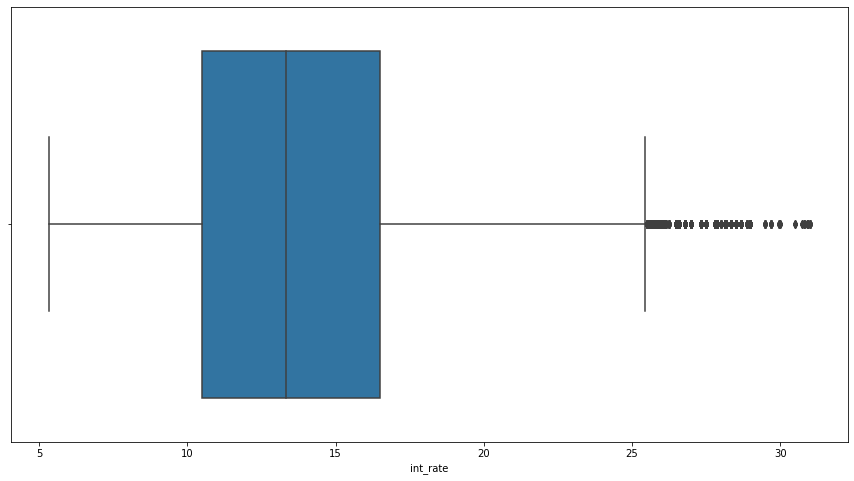

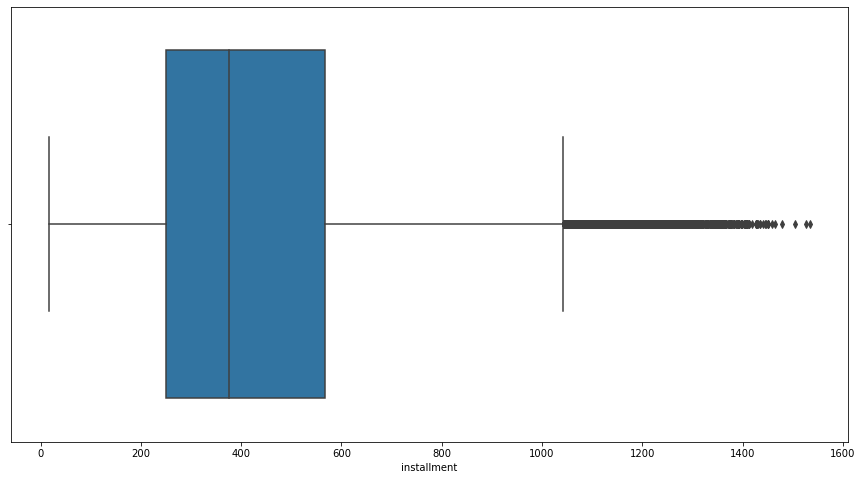

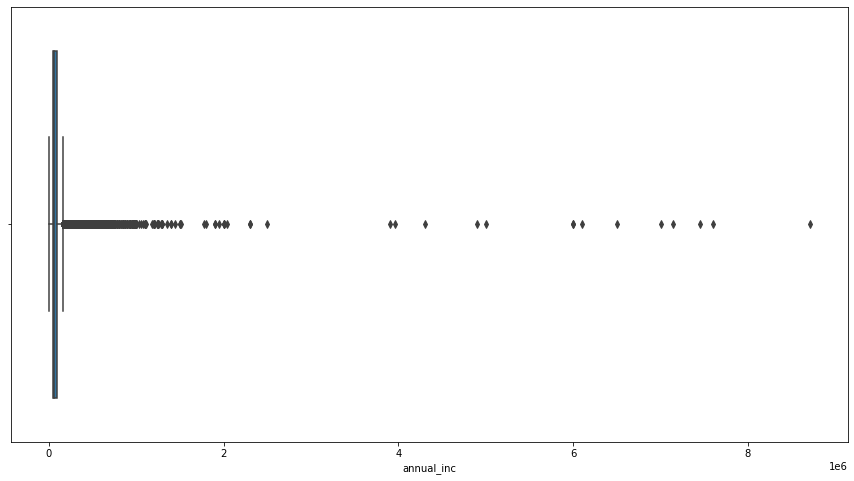

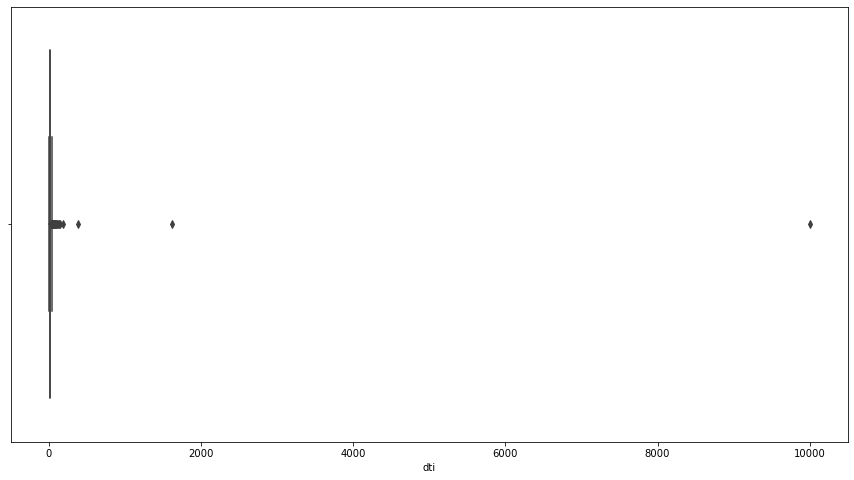

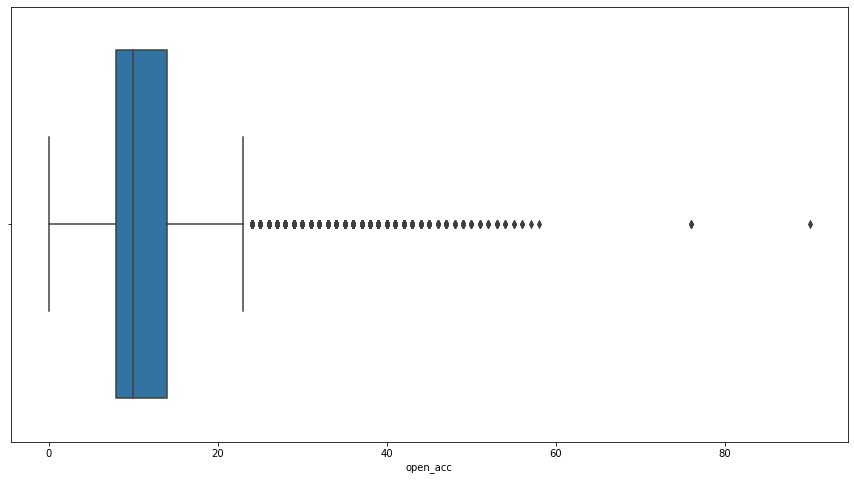

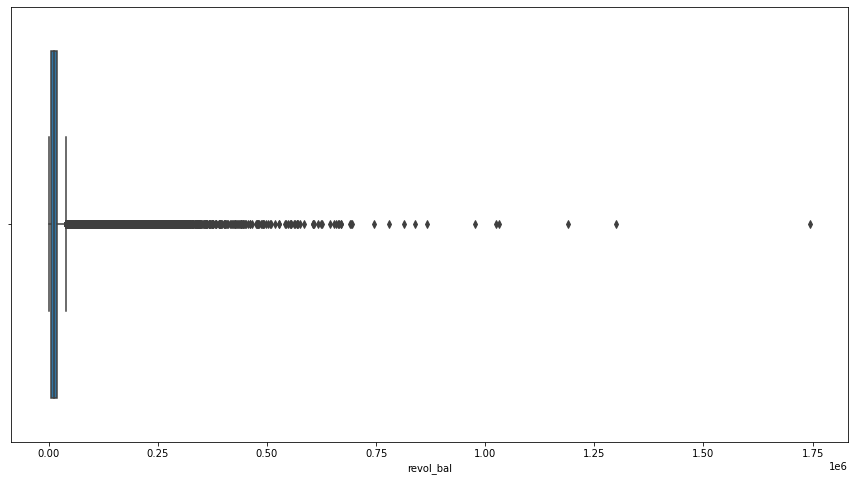

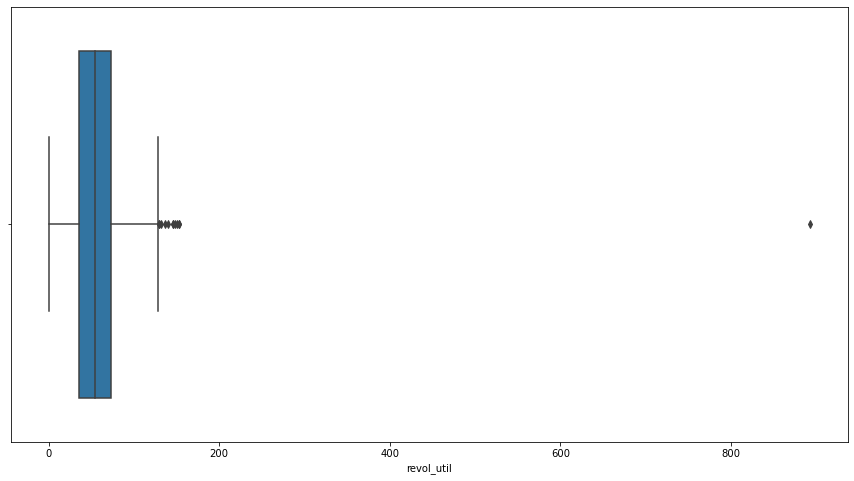

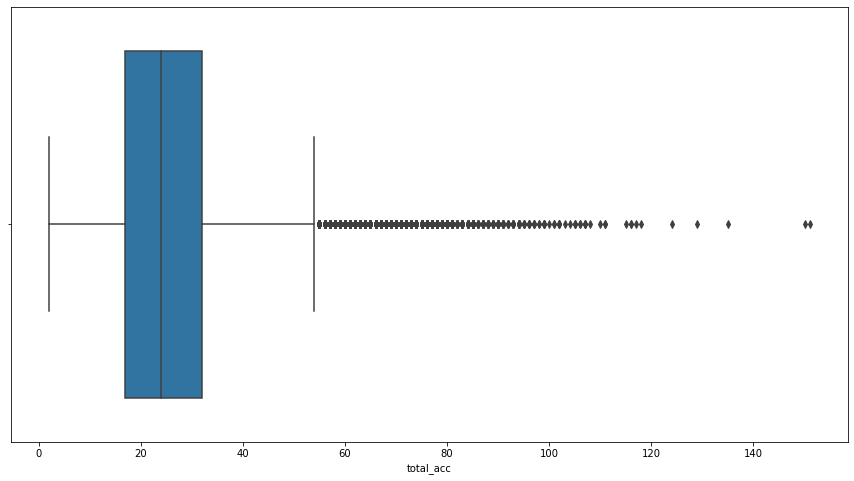

In [630]:
for i in data_num:
    plt.figure(i,figsize=(15,8))
    sns.boxplot(data=data,x=i)

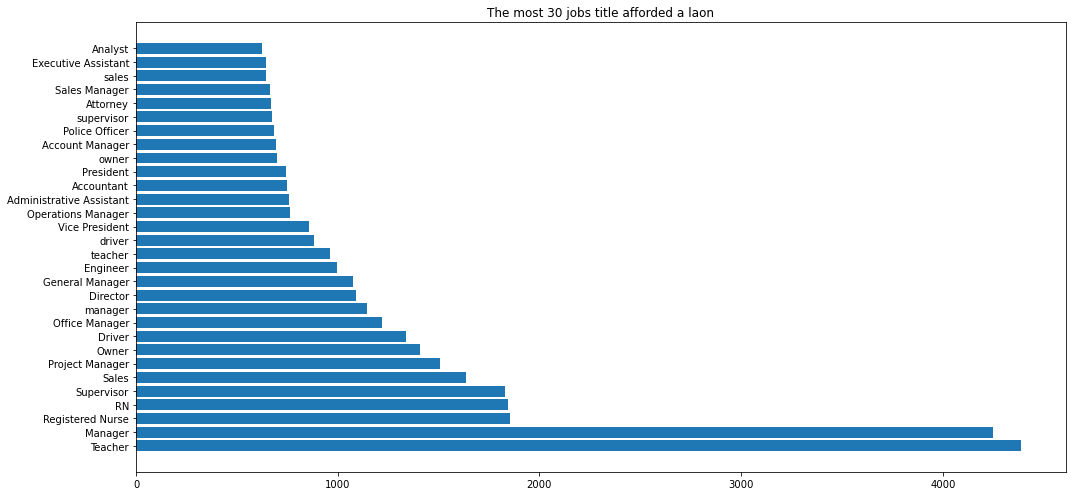

In [631]:
plt.figure(figsize=(15,7))
plt.barh(data.emp_title.value_counts()[:30].index,data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

- dataset is highly imbalanced.
- int_rate, installments, annual_inc, dti, revol_acc, total_acc, open_acc have very high number outliers.
- Maximum people taking 36 month plan
- 10+ years of experience person taking more loan
- Mortrage and Rent home ownership person have dominant number
- All numerical feature are right skewed.

- ### Bivariate Analysis

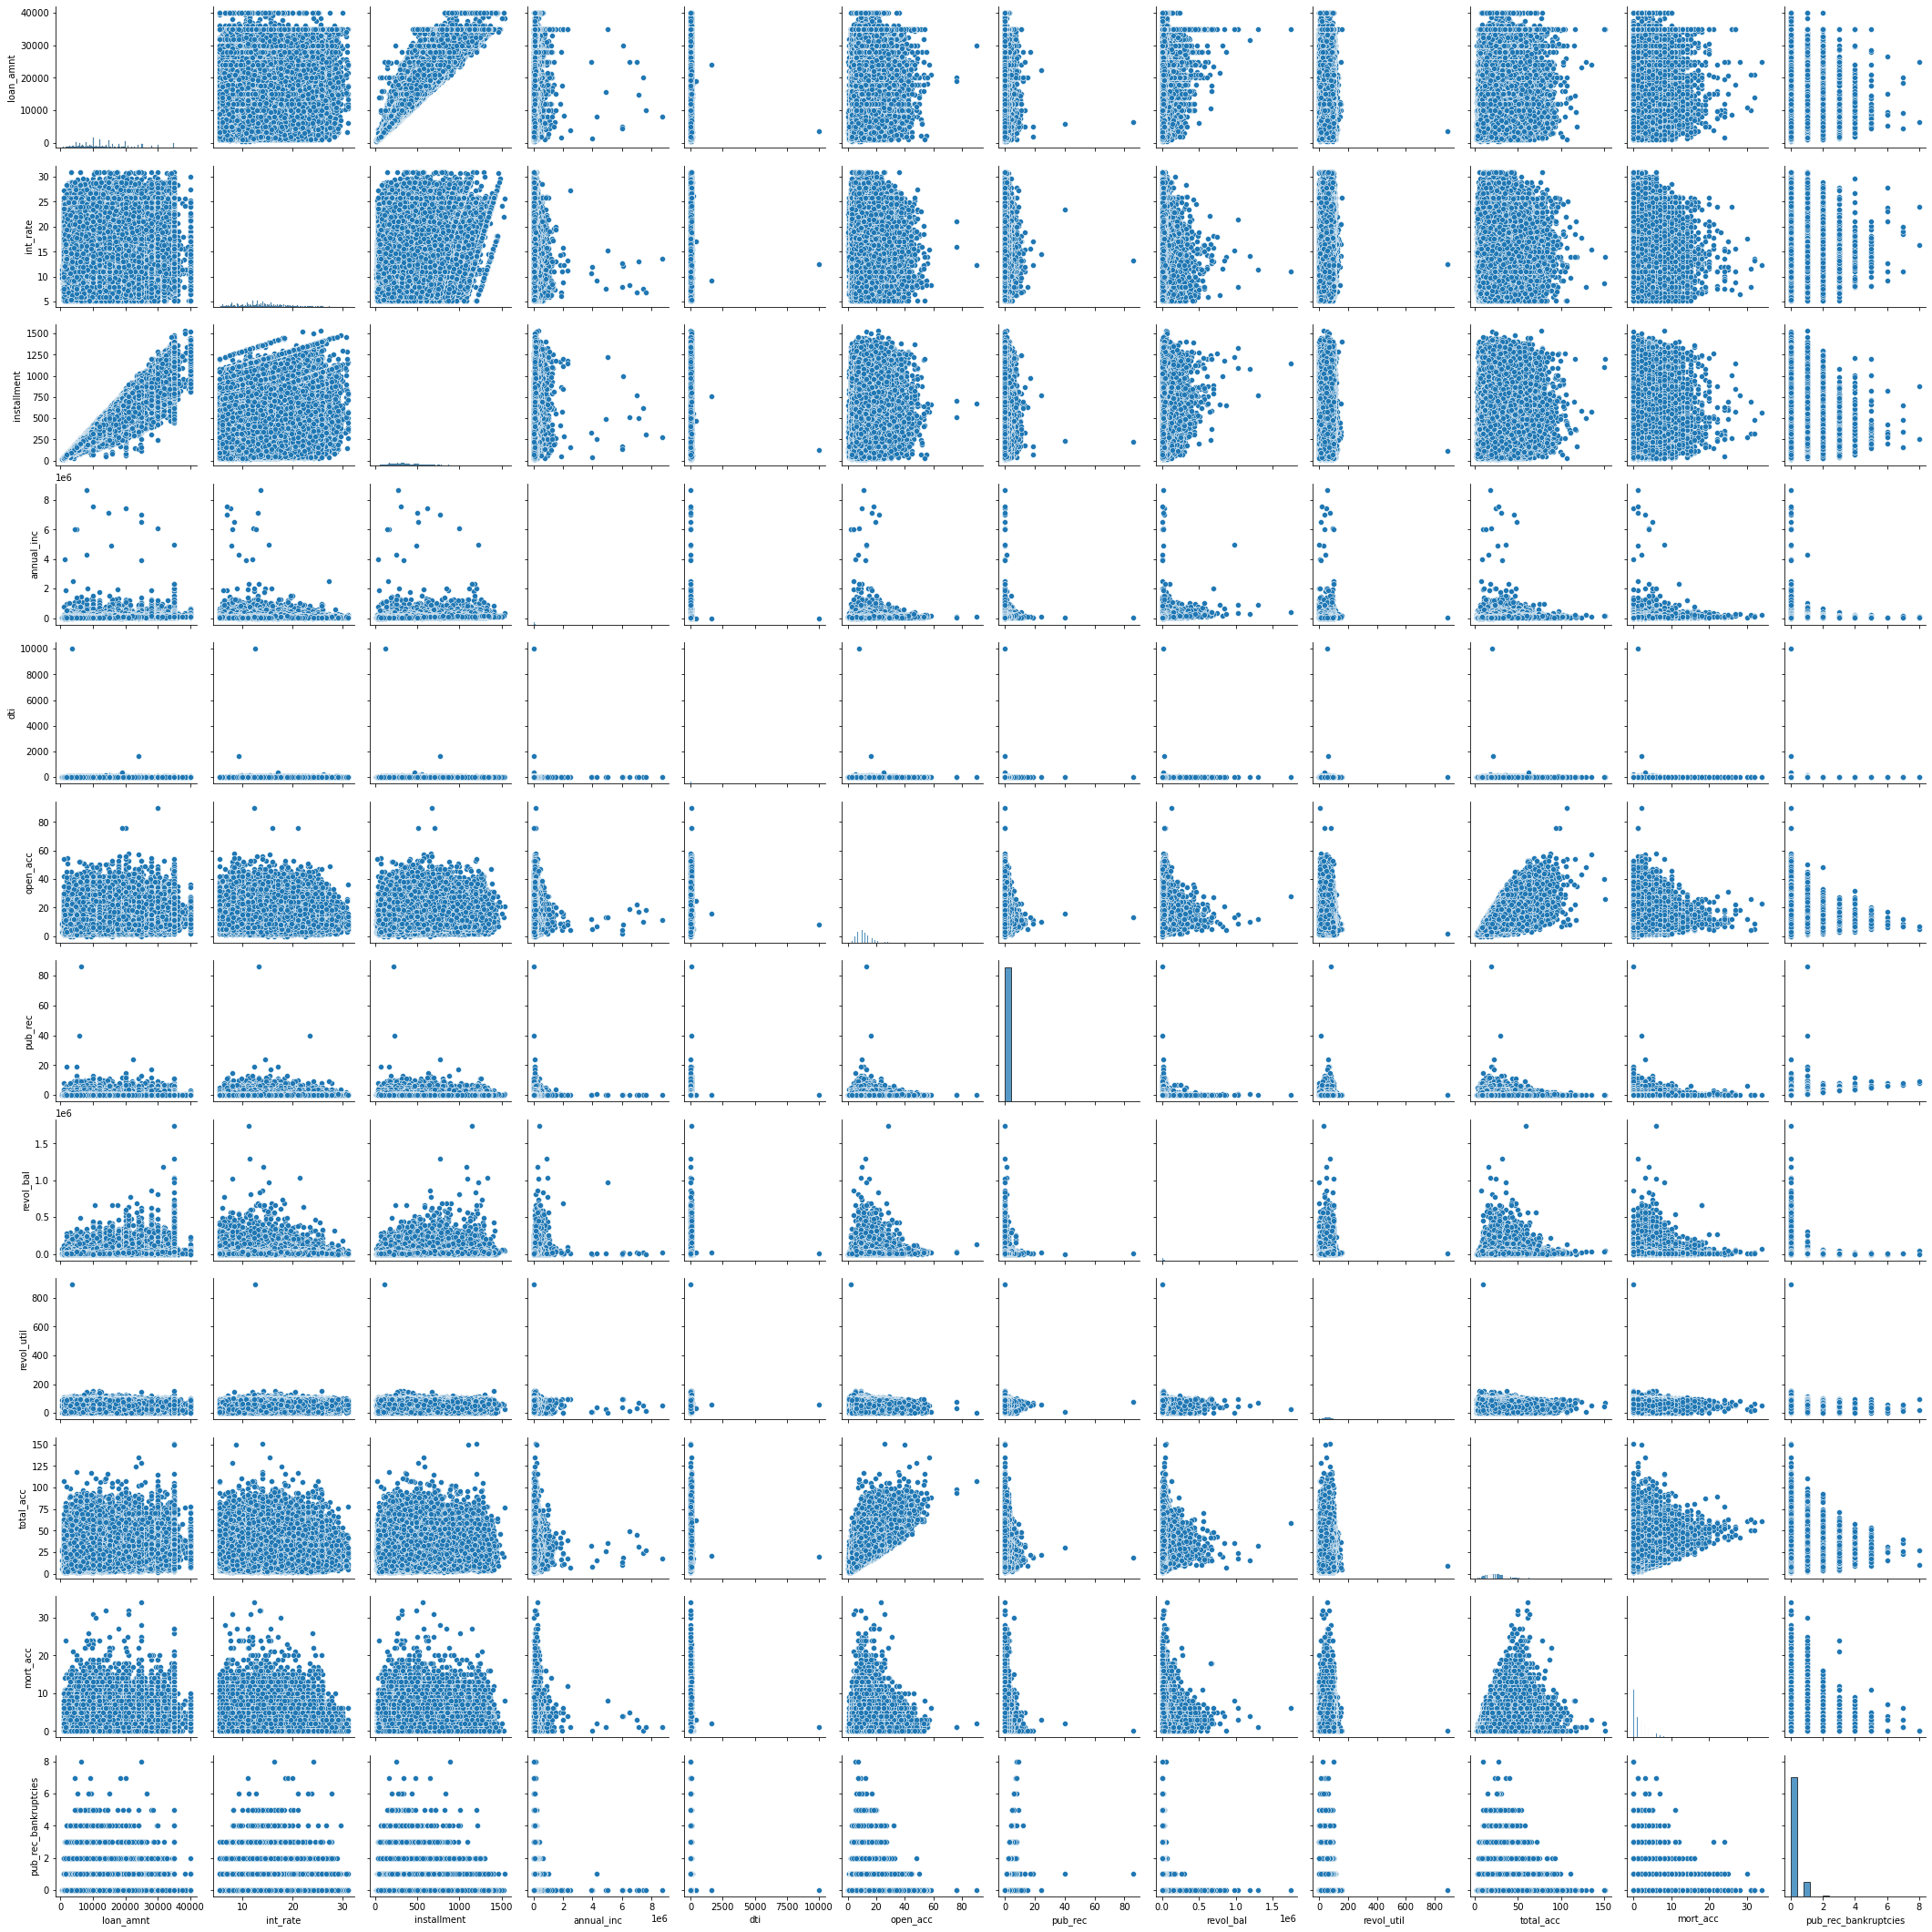

In [632]:
sns.pairplot(data)

<AxesSubplot:xlabel='loan_amnt', ylabel='installment'>

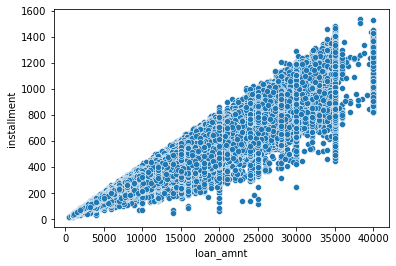

In [633]:
sns.scatterplot(data['loan_amnt'],data['installment'])

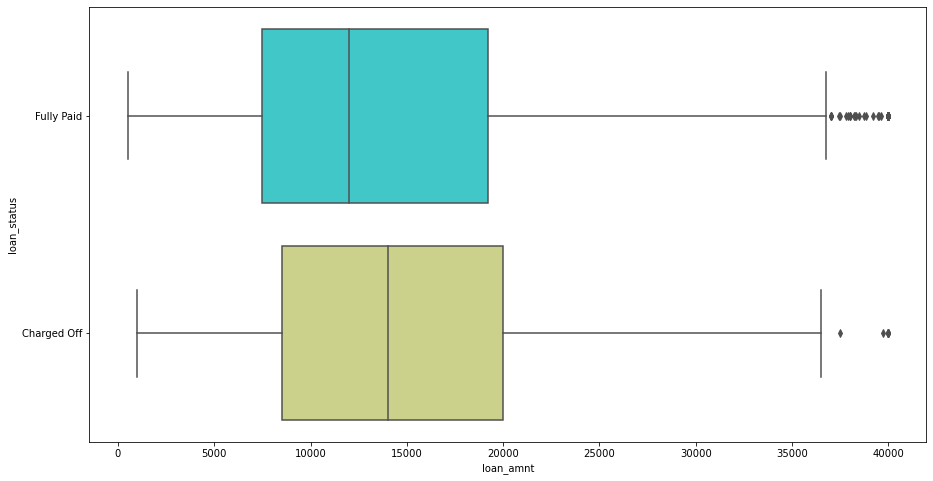

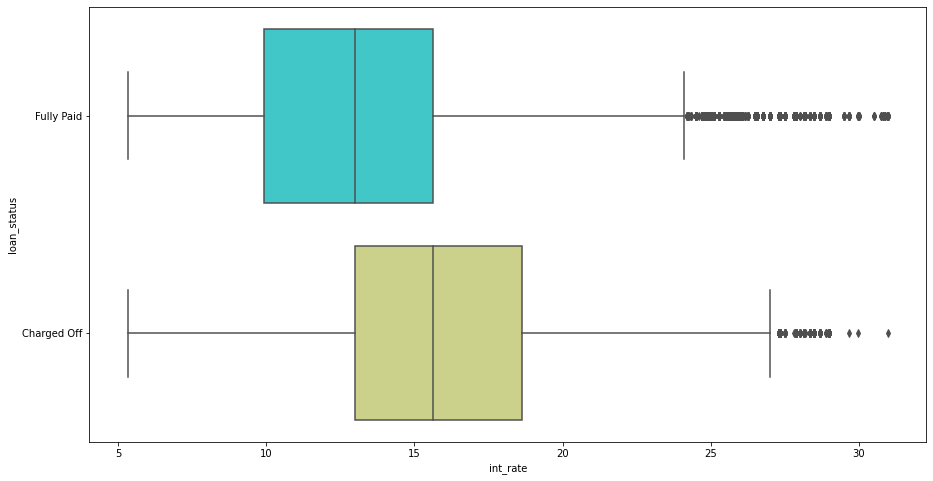

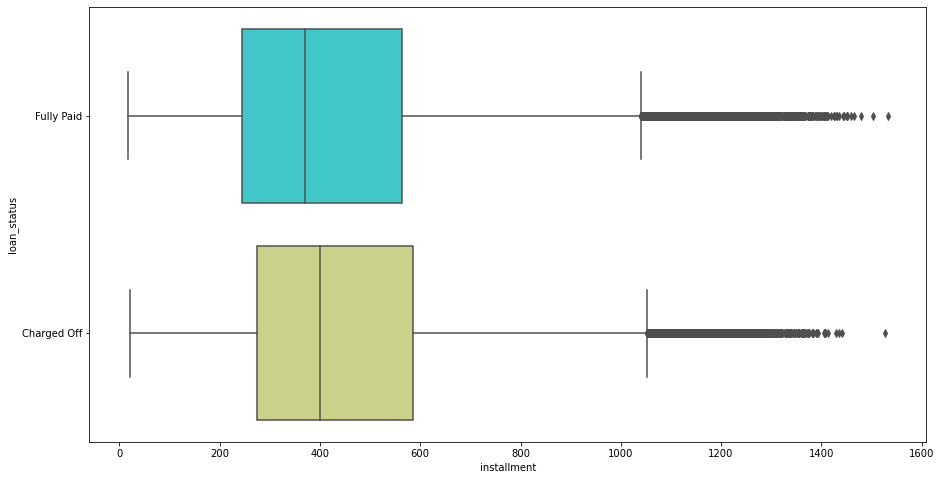

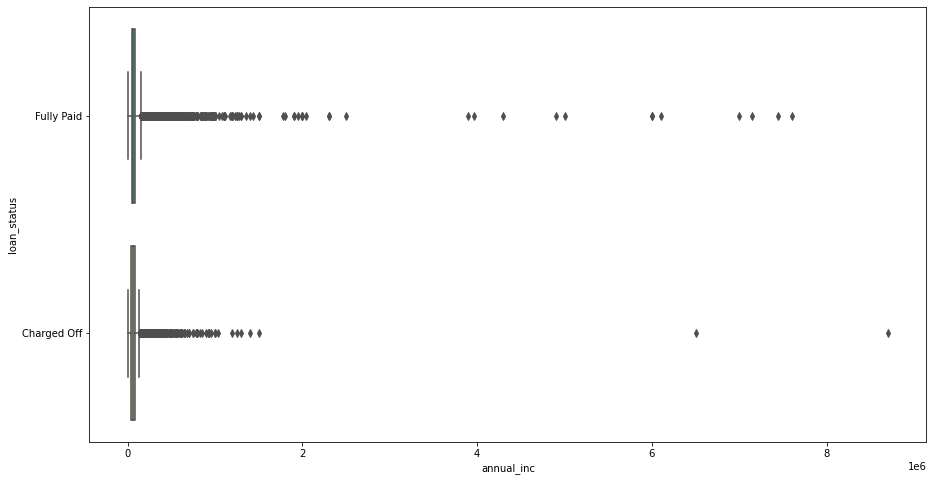

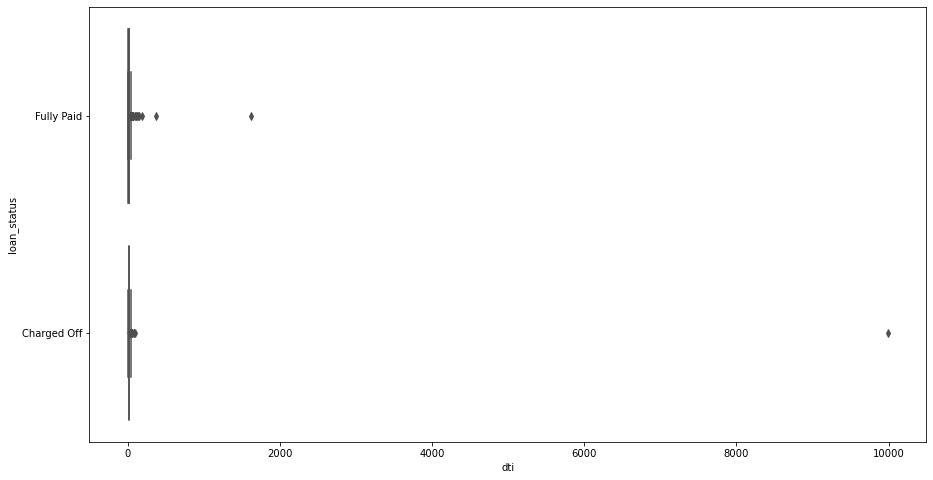

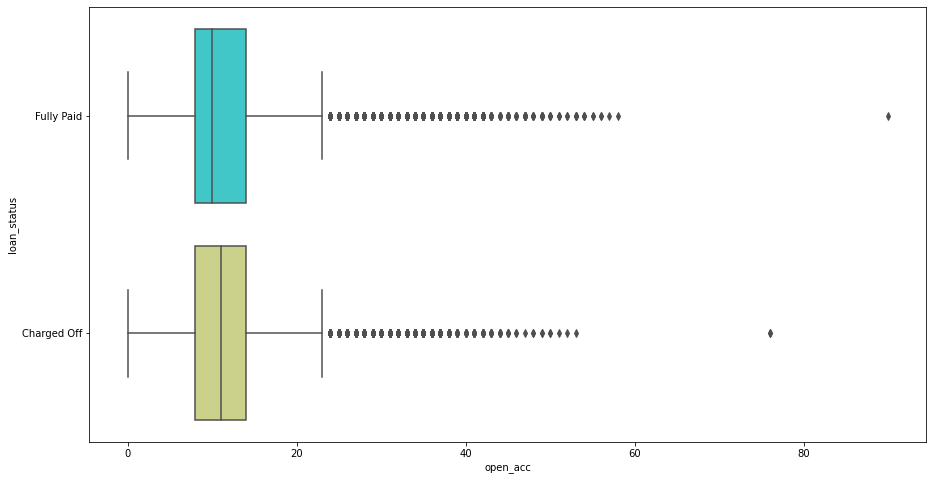

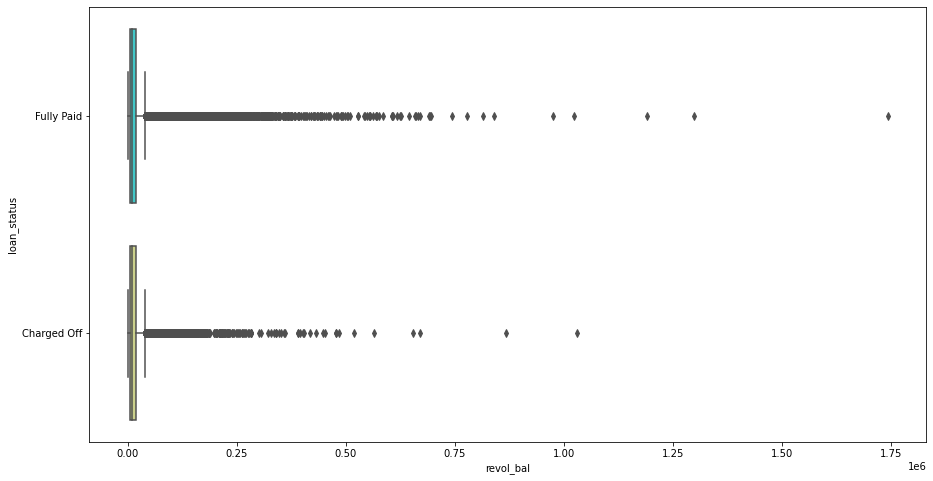

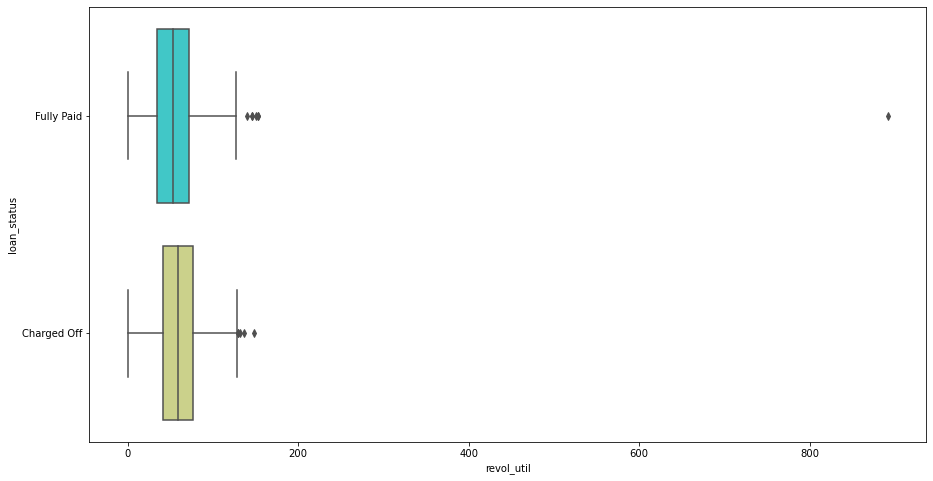

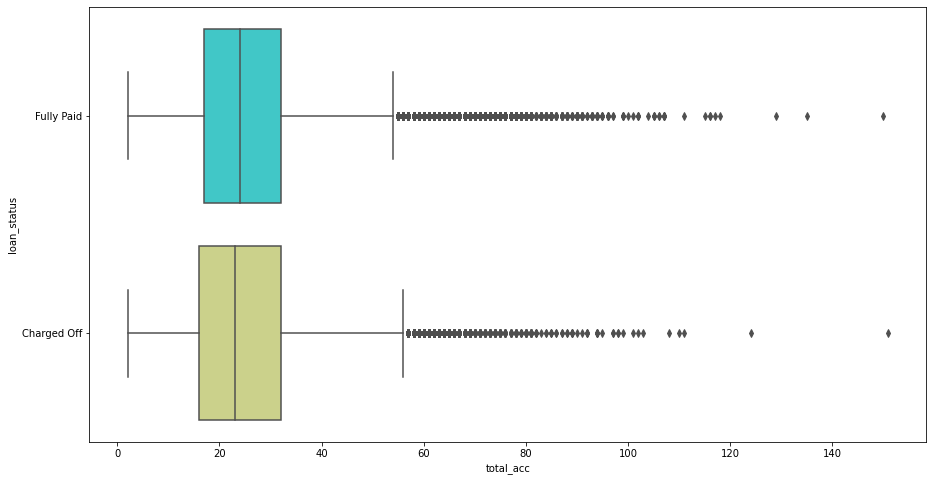

In [634]:
for i in data_num:
    plt.figure(i,figsize=(15,8))
    sns.boxplot(x=i,y='loan_status',data=data,palette='rainbow')

<AxesSubplot:>

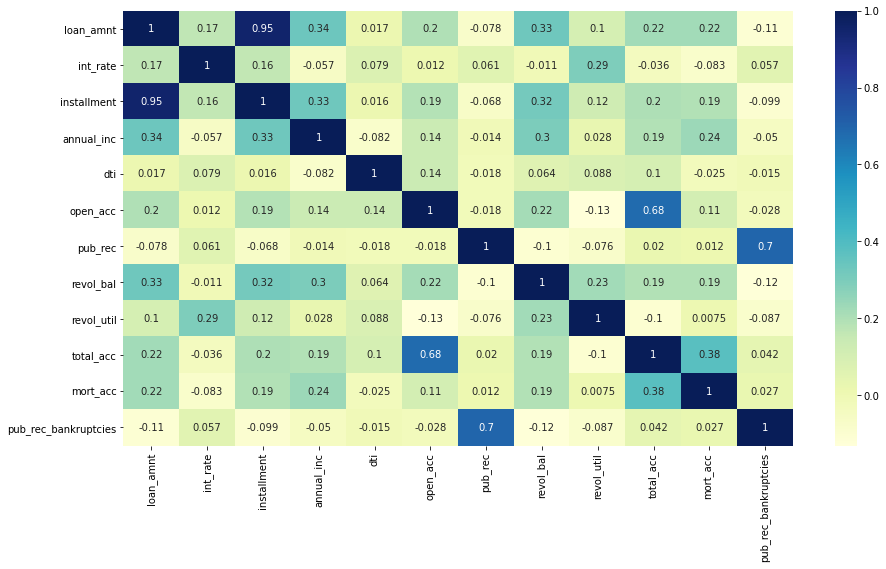

In [635]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

- Installment and loan amount are highly corelated to each other.
- 13% rate of interest is 50 percentile for fully paid and 25 percentile for charged off.

## Data Preprocessing

In [636]:
data=data.drop(["emp_title","issue_d","title","earliest_cr_line","sub_grade","emp_length"],axis=1)

In [637]:
data=data.drop(['installment'],axis=1)

### 1. Duplicate value check

In [638]:
data[data.duplicated()].sum()

loan_amnt               0.0
term                    0.0
int_rate                0.0
grade                   0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
loan_status             0.0
purpose                 0.0
dti                     0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

No duplicates value is present

### 2. Missing value treatment

In [639]:
data.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
grade                       0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
dti                         0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [640]:
median = data['revol_util'].median()
data['revol_util'] = data['revol_util'].fillna(median)

filling null values of revol_util with the median value

In [641]:
data['mort_acc'] = data['mort_acc'].fillna(1)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].fillna(1)

filling null value of mort_acc and pub_rec_bankruptcies with the "1" because "0" is greater in size

In [642]:
data.isna().sum()

loan_amnt               0
term                    0
int_rate                0
grade                   0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

### 3. Outlier treatment

In [689]:
numerical_data=data.select_dtypes(include='number')
num_cols=numerical_data.columns

In [644]:
for col in num_cols:
    mean=data[col].mean()
    std=data[col].std()
    
    upper_limit=mean+3*std
    lower_limit=mean-3*std
    
    data=data[(data[col]<upper_limit) & (data[col]>lower_limit)]
    
data.shape

(365525, 20)

taking three time of standard devaiation more and less from mean as normal data apart from that removing because they are outliers.

### 4. Feature engineering

In [645]:
data['pub_rec'] = data['pub_rec'].apply(lambda x: 1 if x >= 1 else 0)
data['mort_acc'] = data['mort_acc'].apply(lambda x: 1 if x >= 1 else 0)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 1 if x >= 1 else 0)

In [646]:
# Mapping of target variable 
data['loan_status']=data.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [647]:
term_values={' 36 months': 36, ' 60 months':60}
data['term'] = data.term.map(term_values)

In [648]:
list_status = {'w': 0, 'f': 1}
data['initial_list_status'] = data.initial_list_status.map(list_status)

In [649]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [650]:
data['zip_code'].value_counts()

70466    52561
30723    52232
22690    52131
48052    51681
00813    42210
29597    41904
05113    41878
11650    10384
93700    10335
86630    10209
Name: zip_code, dtype: int64

In [651]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'zip_code'],
      dtype='object')

In [652]:
dummies_col = ["grade","home_ownership","zip_code","verification_status","purpose","application_type"]
data=pd.get_dummies(data,columns=dummies_col,drop_first=True)

one hot encoding

In [653]:
data=data.drop(['address'],axis=1)

In [654]:
data.head()

,loan_amnt,term,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_INDIVIDUAL,application_type_JOINT
0,10000.0,36,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,...,0,0,0,0,0,0,1,0,1,0
1,8000.0,36,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,...,0,0,0,0,0,0,0,0,1,0
2,15600.0,36,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,...,0,0,0,0,0,0,0,0,1,0
3,7200.0,36,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,...,0,0,0,0,0,0,0,0,1,0
4,24375.0,60,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,...,0,0,0,0,0,0,0,0,1,0


In [655]:
data.shape

(365525, 51)

### 5. Data preparation for modeling

In [656]:
X = data.drop('loan_status',axis=1)
y = data[['loan_status']]

In [657]:
X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.25,random_state=1,stratify=y_tr_cv)

In [658]:
print(X_train.shape,X_test.shape,X_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)

(219315, 50) (73105, 50) (73105, 50)
(219315, 1) (73105, 1) (73105, 1)


In [659]:
sm=SMOTE(random_state=42)
X_train,y_train=sm.fit_resample(X_train,y_train)

Using Smote technique for oversampling the data.

In [660]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
  
print("After OverSampling, counts of label 1: {}".format(sum(y_train['loan_status'] == 1)))
print('After OverSampling, counts of label 0: {}'.format(sum(y_train['loan_status'] == 0)))

After OverSampling, the shape of train_X: (352342, 50)
After OverSampling, the shape of train_y: (352342, 1) 

After OverSampling, counts of label 1: 176171
After OverSampling, counts of label 0: 176171


In [661]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [662]:
def accuracy(y_true, y_pred):
    y_true = y_true.values.reshape(len(y_true))
    return np.sum(y_true==y_pred)/y_true.shape[0]

In [663]:
train_scores = []
val_scores = []
sc = StandardScaler()
for la in np.arange(0.01, 5000.0, 100): # range of values of Lambda
    scaled_lr = make_pipeline(sc, LogisticRegression(C=1/la))
    scaled_lr = make_pipeline(sc, LogisticRegression(C=1/la))
    scaled_lr.fit(X_train, y_train)
    train_score = accuracy(y_train, scaled_lr.predict(X_train))
    val_score = accuracy(y_val, scaled_lr.predict(X_val))
    train_scores.append(train_score)
    val_scores.append(val_score)

Checking the accurate lambda value for the model with the help of validation data

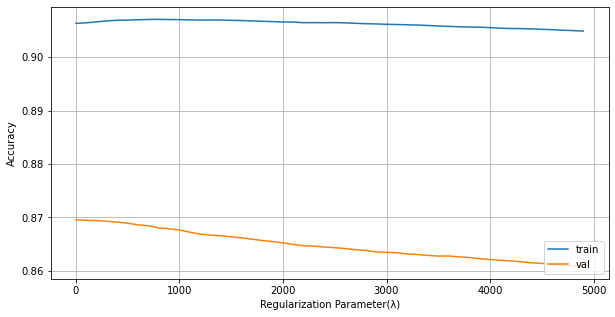

In [664]:
plt.figure(figsize=(10,5))
plt.plot(list(np.arange(0.01, 5000.0, 100)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 5000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')

plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## Model building

In [665]:
model=LogisticRegression(C=1/500)
model.fit(X_train,y_train)

LogisticRegression(C=0.002)

In [666]:
print('Accuracy of Logistic Regression Classifier on train set: {:.3f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on validation set: {:.3f}'.format(logreg.score(X_val, y_val)))
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on train set: 0.907
Accuracy of Logistic Regression Classifier on validation set: 0.868
Accuracy of Logistic Regression Classifier on test set: 0.867


In [667]:
model.coef_

array([[ 0.15447456,  0.24230291,  1.26007837, -0.15551113,  0.20939823,
         0.10091532,  0.02072214, -0.07833206,  0.15290854, -0.05577034,
        -0.19279223, -0.18290777, -0.07440586, -0.67847981, -0.8279282 ,
        -0.89017751, -0.7963395 , -0.5959547 , -0.28532041, -1.50132455,
        -0.02388497, -0.04838529, -0.80181447, -1.43762894, -1.14529903,
         0.87522784, -0.17308467, -1.14963745, -0.17499601, -0.15694041,
        -0.16992693,  0.85844535,  0.87782022, -0.18353282, -0.24633107,
        -0.96019982, -1.18385376, -0.04226879, -0.4871681 , -0.16501678,
        -0.31910162, -0.2114169 , -0.17613155, -0.47276147, -0.05642384,
        -0.19897519, -0.17062446, -0.17851618, -0.01629657, -0.04857304]])

In [668]:
model.intercept_

array([0.73371401])

In [707]:
# checking cross validation score
score_lr=cross_val_score(LogisticRegression(), X_val, y_val,cv=5)
print(score_lr)
print("Avg :",np.average(score_lr))

[0.89159428 0.8861227  0.88892689 0.88974762 0.88858491]
Avg : 0.8889952807605498


<AxesSubplot:ylabel='Feature'>

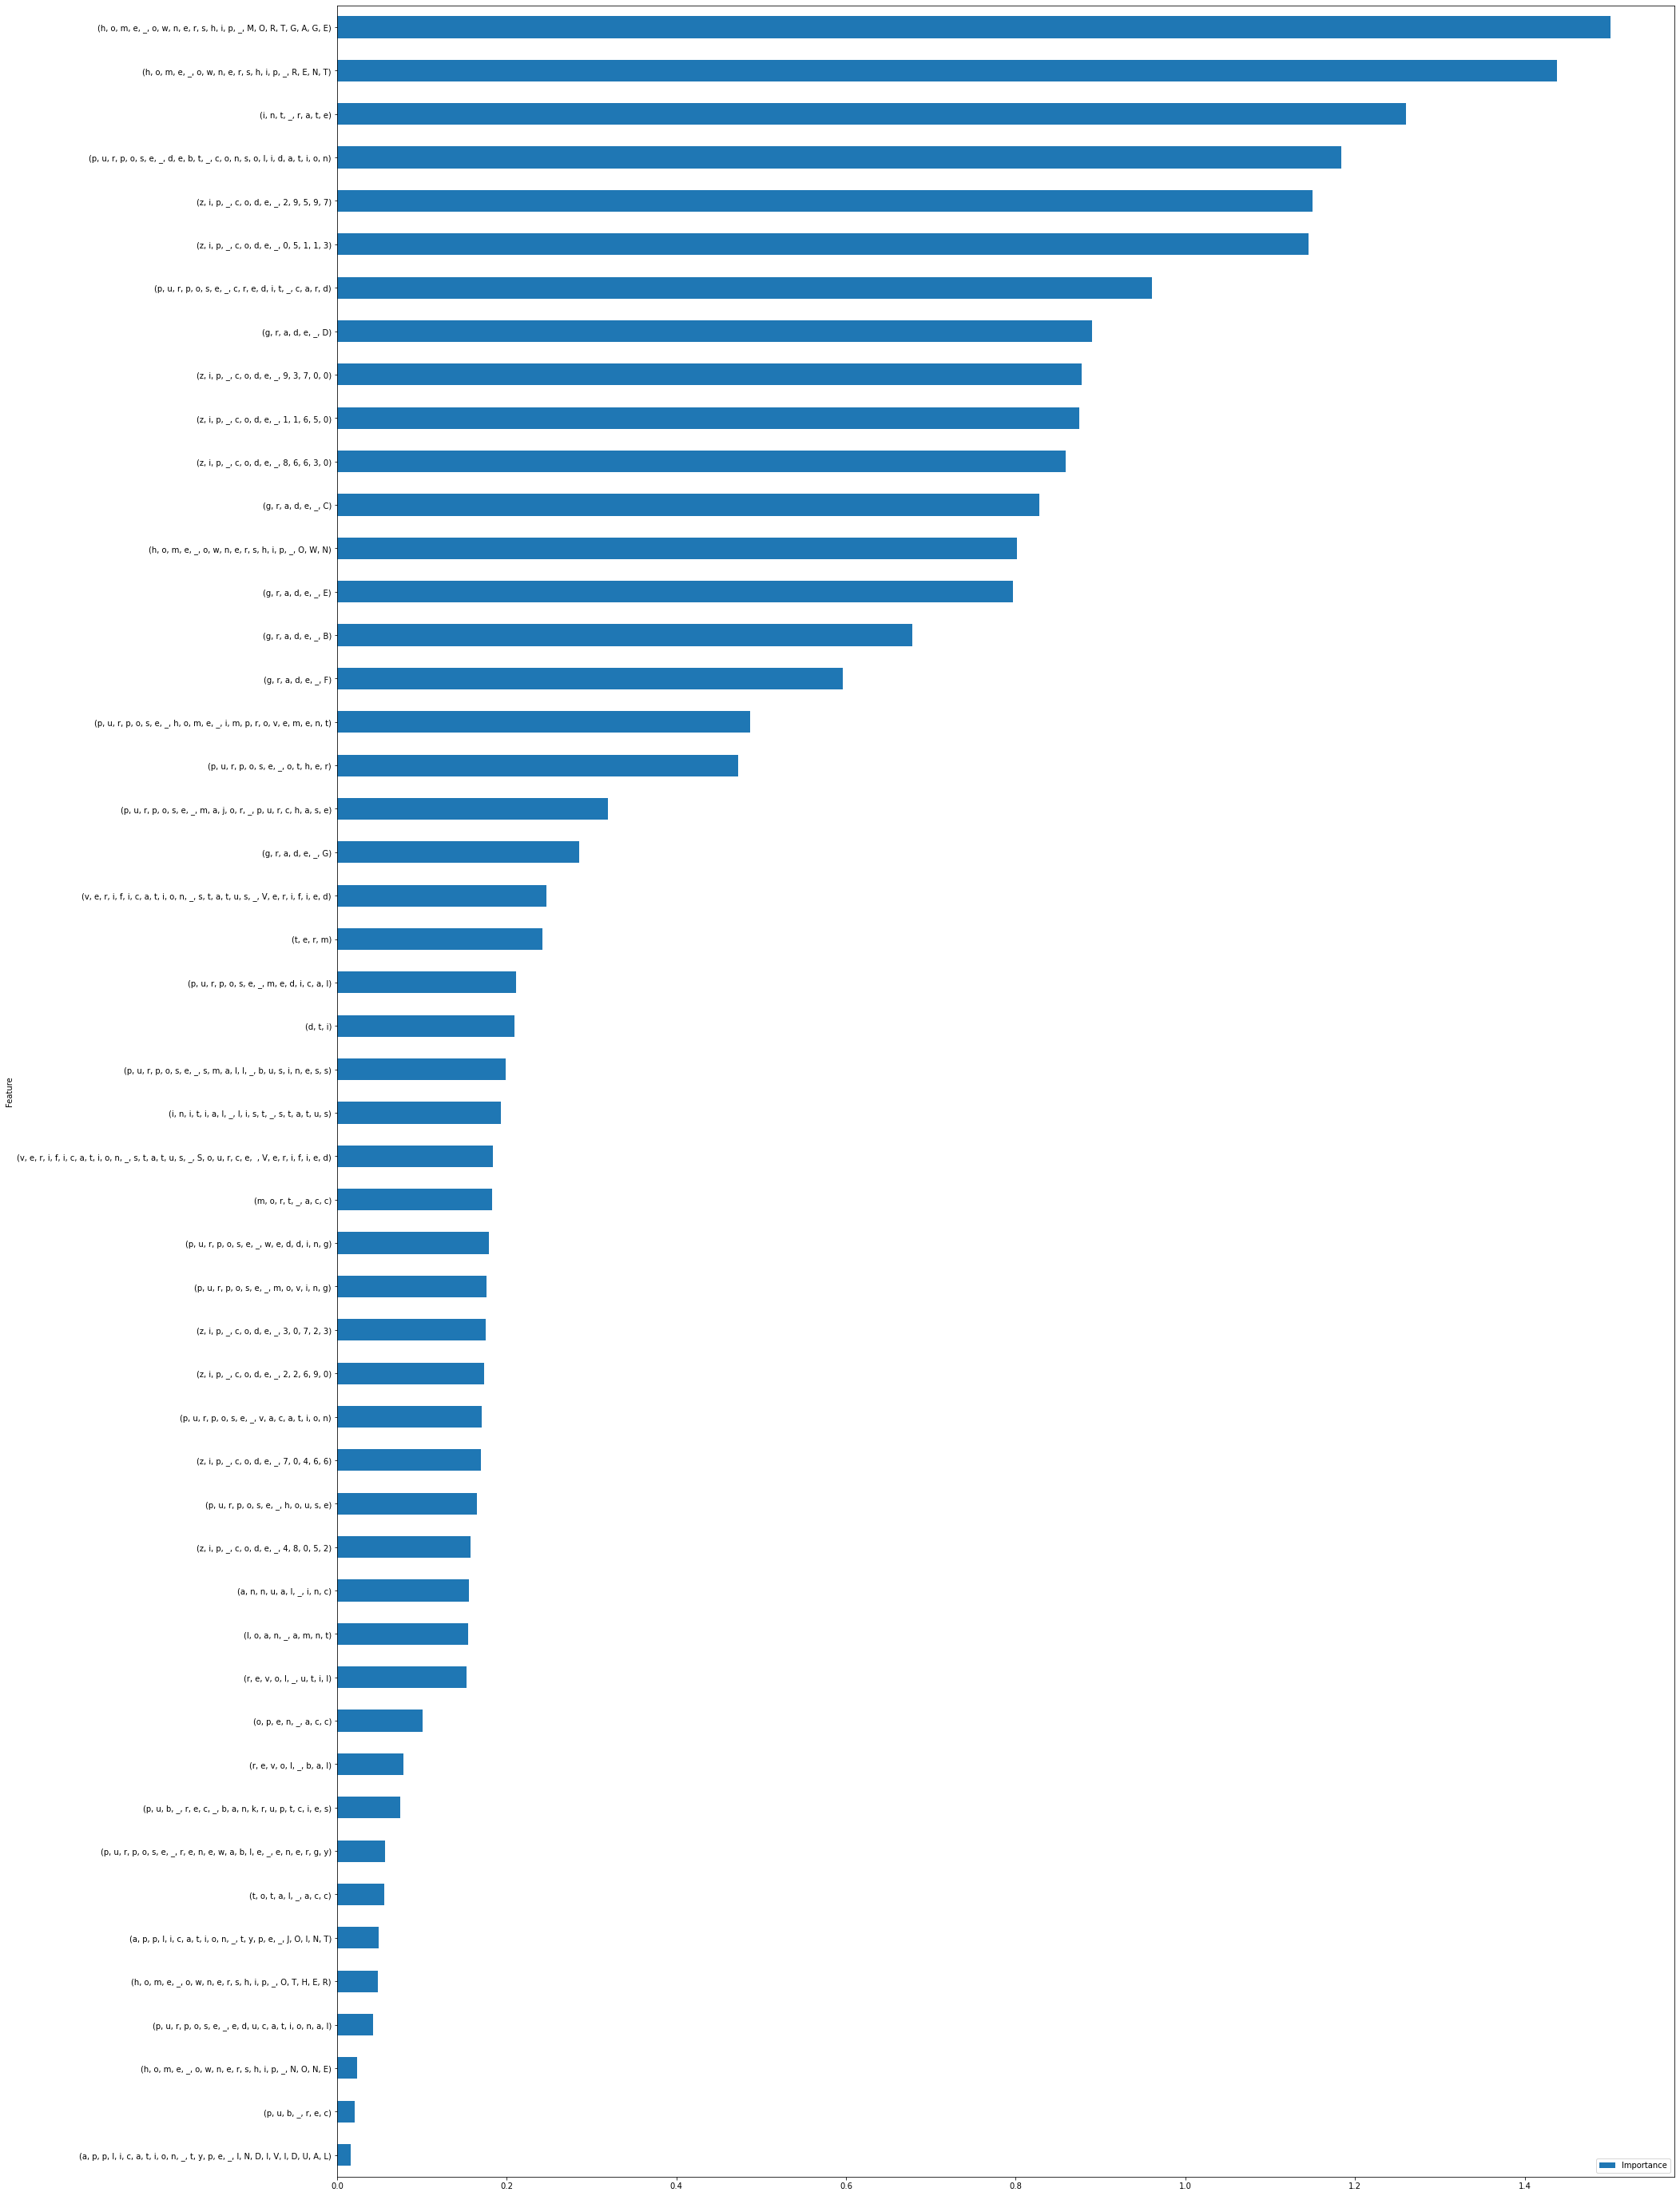

In [674]:
coefficients = model.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(30,50))

## Results Evaluation

### 1. ROC AUC Curve & comments

In [676]:
probability = model.predict_proba(X_test)

In [677]:
probability

array([[0.29346712, 0.70653288],
       [0.00277887, 0.99722113],
       [0.99761274, 0.00238726],
       ...,
       [0.99795889, 0.00204111],
       [0.69728686, 0.30271314],
       [0.90768234, 0.09231766]])

In [678]:
probabilites = probability[:,1]

In [679]:
fpr, tpr, thr = roc_curve(y_test,probabilites)

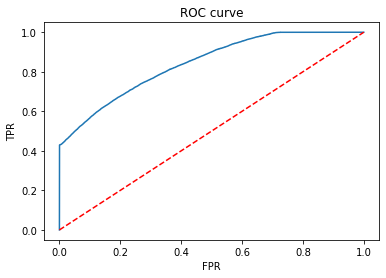

In [680]:
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [681]:
# AUC
roc_auc_score(y_test,probabilites)

0.8416642860615695

ROC AUC score is pretty good that means our model is oredicting 1 to 1 and 0 to 0 correctly.

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

### 2. Precision Recall Curve & comments

In [682]:
precision, recall, thr = precision_recall_curve(y_test, probabilites)

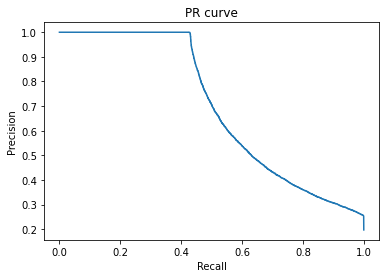

In [683]:
plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.show()

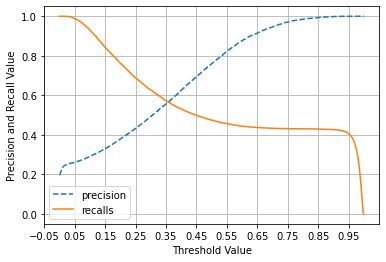

In [684]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')
    
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Curve is looking good.

### 3. Classification Report (Confusion Matrix etc)

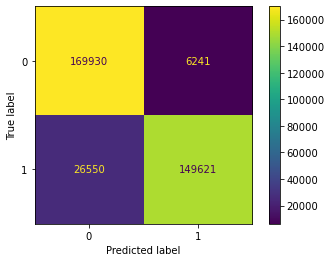

In [693]:
y_pred = model.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

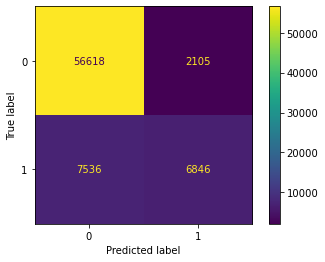

In [691]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

In [692]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     58723
           1       0.76      0.48      0.59     14382

    accuracy                           0.87     73105
   macro avg       0.82      0.72      0.75     73105
weighted avg       0.86      0.87      0.86     73105



Precision Score:  0.9599581681230832
Precision matrix


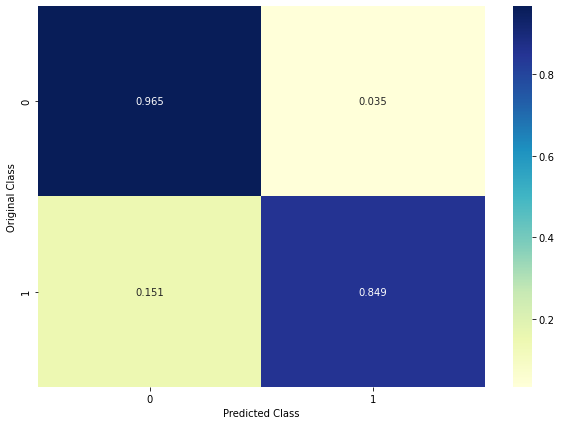

In [695]:
Precision =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)
print("Precision Score: ",precision_score(y_train, y_pred))
print("Precision matrix")
plt.figure(figsize=(10,7))
sns.heatmap(Precision, annot=True, cmap="YlGnBu", fmt=".3f")
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

Recall Score:  0.8492941517048777
Recall matrix


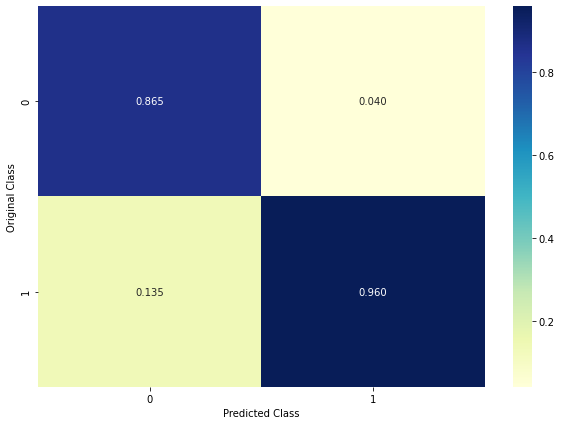

In [696]:
print("Recall Score: ",recall_score(y_train, y_pred))
Recall =(conf_matrix/conf_matrix.sum(axis=0))
print("Recall matrix")
plt.figure(figsize=(10,7))
sns.heatmap(Recall, annot=True, cmap="YlGnBu", fmt=".3f")
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### 4. Tradeoff Questions:

#### 1. How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

=> To keep very less False Positives, oversampling techniques like SMOTE should be used in model creation. Also we can use more complex algorithms like SVM, Decision-Trees, Random Forest and also try various hyperparameter tunning.

=> As you can see from the data, the percentage of defaulters is slightly higher than Banking industry.

 

 

#### 2. Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.

=> Yes. LoanTap should not disburse loans to everyone. Company’s internal policy and analysis should be in place to identify the correct persons. From data provided, 20% of people default on their loan, which become NPAs for the company.

=> Low False positive means we should create the model with high Precision values. This can be achieved if we are keeping high threshold value in logistic Regression model.

=> But keeping too high values for threshold will increase False Negatives. This intuen may result in opportunity loss. In this case we will not give loans to persons which will not default but our model has predicted that they will default. 

## Actionable Insights & Recommendations

- Around 80.39% of customers have fully paid their Loan Amount. The defaulters are ~ 20%. From Personal loan business perspective this ratio is high. These 20% will contribute in NPAs of LoanTap. To reduce the risk of NPAs,
- LoanTap should add slightly stringent rules to bring down this ratio to 5% to 6%.
- LoanTap should provide loans at slightly higher rate than other Banks. This will offset the risks of defaulters and maintain the profitability of the business.


- #### Overall Statistics of the Model:
- Accuracy = 87%
- Precision = 88
- Recall = 96
- F1 -score = 92%

- Model created has high values for accuracy, precision, recall & f1-score. This means, this model is a good classifier. Overall, it has good prediction capability in identifying right customers (which can be easily converted).
- Those person who has high rate of interest, they charged off. Company should give some relaxation in rate of interest.
- However this model has slightly low capability on correctly identifying defaulters. Overall data has 20% defaulters, model is able to predict 10% of them correctly.
- Using this model, LoanTap can easily reduce the ration of defaulters in their portfolio.
- application_type JOINT has positive Coefficient. Which means LoanTap can promote persons to apply for joint loan. Because of this, chances of default will reduce.
- Purpose Renewable energy has negative Coefficient. This means LoanTap should stick to giving loans to conventional purposes like Marriage, car etc.
- term 60 months has negative Coefficient. Which means LoanTap should focus more on Loans for shorter duration (i.e. 36 months). Their social media campaign and marketing strategy should be based on this consideration.

## Questionnaire

#### 1. What percentage of customers have fully paid their Loan Amount?

80.39%

#### 2. Comment about the correlation between Loan Amount and Installment features.

the spearman correlation coefficient between Loan Amount and Installment features is very high. It is around 0.95.

#### 3. The majority of people have home ownership as _______.

Majority of people have home ownership as Mortgage and Rent.

- MORTGAGE    198348 (~50.08%)
- RENT        159790 (~40.35)

#### 4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

Yes, Out of all people with grade 'A', 93.7% paid loan fully.

#### 5. Name the top 2 afforded job titles.

Teacher and Manager

#### 6. Thinking from a bank's perspective, which metric should our primary focus be on..
- #### ROC AUC
- #### Precision
- #### Recall
- #### F1 Score

F1 Score metric should be our primary focus because both precision and recall is important.
- ROC-AUC : Not good metric to consider as we have highly imbalanced data.
- Precision: Consider when only want to reduce NPA
- Precision: lower precision will lead to losing the business by misppredicting disciplined payees as defaulters
- Recall: lower recall will lead to risk by disbursing the loans to defaulter by mispredicting defaulters as disciplined payees

#### 7. How does the gap in precision and recall affect the bank?

- Recall score: 0.96 and Precision score: 0.88. which tells us that there are more false positives than the false negatives. 

- If Recall value is low,  it means Bank is loosing in opportunity cost.

- If Precision value is low, it means Bank's NPA (defaulters) may increase.

#### 8. Which were the features that heavily affected the outcome?

int_rate,
sub_grade,
term,
home_ownership,
purpose,
application_type,
zipcode (from address),
Mortrage Account

#### 9. Will the results be affected by geographical location? (Yes/No)

Yes, zipcode has significant impact on the outcome